Matrix([[1, 0, 0, -7*sin(psi)*cos(theta)/40, -7*sin(theta)*cos(psi)/40, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 7*cos(psi)*cos(theta)/40, -7*sin(psi)*sin(theta)/40, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, -7*cos(theta)/40, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 7*sin(psi)*cos(theta)/40, 7*sin(theta)*cos(psi)/40, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, -7*cos(psi)*cos(theta)/40, 7*sin(psi)*sin(theta)/40, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 7*cos(theta)/40, 0, 0, 0, 0, 0, 0, 0]])
Matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 7/40, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, -7/40, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, -7/40, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 7/40, 0, 0, 0, 0, 0, 0, 0]])
array([10.175, 10.   , 10.   ,  9.825, 10.   , 10.   ])


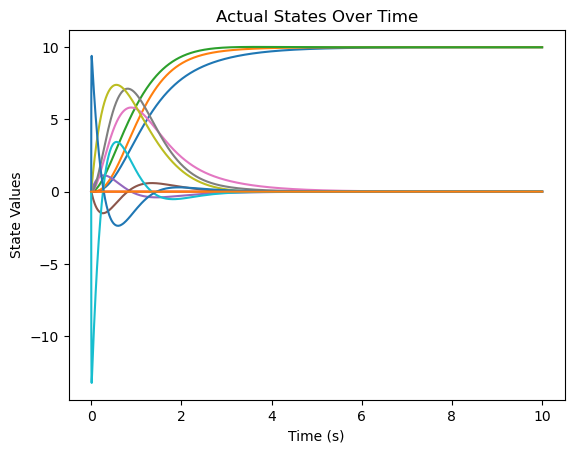

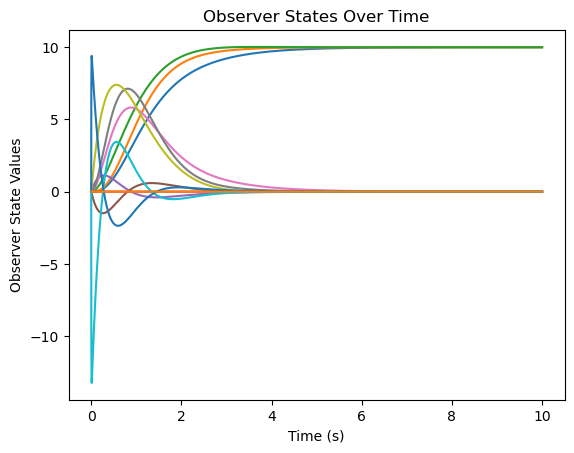

In [1]:
from sympy import *
import numpy as np
from control import ctrb, acker, obsv, lqr
from scipy.signal import place_poles, StateSpace
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

# components of position (meters)
p_x, p_y, p_z = symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = symbols('v_x, v_y, v_z')
v_in_body = Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = symbols('w_x, w_y, w_z')
w_in_body = Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = symbols('f_z')

# parameters
m = nsimplify(params['m'])
Jx = nsimplify(params['Jx'])
Jy = nsimplify(params['Jy'])
Jz = nsimplify(params['Jz'])
l = nsimplify(params['l'])
g = nsimplify(params['g'])
J = diag(Jx, Jy, Jz)

# rotation matrices
Rz = Matrix([[cos(psi), -sin(psi), 0], [sin(psi), cos(psi), 0], [0, 0, 1]])
Ry = Matrix([[cos(theta), 0, sin(theta)], [0, 1, 0], [-sin(theta), 0, cos(theta)]])
Rx = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = simplify(Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ Matrix([[0], [0], [-m * g]]) + Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = simplify(f, full=True)

# Position of drone in world frame
p_in_world = Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = Matrix([l, 0, 0])  # <-- marker on front rotor
b_in_body = Matrix([-l, 0, 0]) # <-- marker on rear rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = simplify(Matrix.vstack(a_in_world, b_in_world))

#linearizing system

w = Matrix([[p_x],
           [p_y],
           [p_z],
           [psi],
           [theta],
           [phi],
           [v_x],
           [v_y],
           [v_z],
           [w_x],
           [w_y],
           [w_z]])

p = Matrix([[tau_x],
           [tau_y],
           [tau_z],
           [f_z]])

# Concatenate w and p separately
wp_combined = Matrix.vstack(w, p)

# Set up the equations
equations = [f_i.subs({v_x: 0, v_y: 0, v_z: 0}) for f_i in f]

# Solve the equations
solution = solve(equations, wp_combined)

#Set w0 and p0
w0 = Matrix([[p_x],
           [p_y],
           [p_z],
           [psi],
           [solution[0][4]],
           [solution[0][5]],
           [v_x],
           [v_y],
           [v_z],
           [solution[0][9]],
           [solution[0][10]],
           [solution[0][11]]])

p0 = Matrix([[solution[0][12]],
           [solution[0][13]],
           [solution[0][14]],
           [solution[0][15]]])

w0 = w0.subs({p_x:10,p_y:10,p_z:10,psi:0,v_x:0,v_y:0,v_z:0})

#Verify Equilibrium

'''print(f.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]}))

print(g.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]}))

'''
#Solving for state-space form

A_sym = f.jacobian(w)
A = A_sym.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]})

B_sym = f.jacobian(p)
B = B_sym.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]})

C_sym = g.jacobian(w)

C = C_sym.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]})

r0 = g.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
                v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]})
r0 = np.array(r0).astype(np.float64)
r0 = r0.flatten()

#Check Whether W and O are Full rank. If W and O are full rank than the system is controllable and observable

A_num = np.array(A).astype(np.float64)
B_num = np.array(B).astype(np.float64)
C_num = np.array(C).astype(np.float64)
w0_num = np.array(w0).astype(np.float64)

W = ctrb(A_num, B_num)
O = obsv(A_num, C_num)

rank_W = np.linalg.matrix_rank(W)
rank_O = np.linalg.matrix_rank(O)

num_states = A_num.shape[0]
is_full_rank_W = (rank_W == num_states)
is_full_rank_O = (rank_O == num_states)

#print(is_full_rank_W,is_full_rank_O)

#Design Observer and Controller for System with eigenvalues
#eig_K = np.array([-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12])
#eig_L = np.array([-100,-200,-300,-400,-500,-600,-700,-800,-900,-1000,-1100,-1200])

#Creating Q and R Matrices
R = np.array([[1,0,0,0],
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1]])

Qc = np.array([[1,0,0,0,0,0,0,0,0,0,0,0],
              [0,2,0,0,0,0,0,0,0,0,0,0],
              [0,0,3,0,0,0,0,0,0,0,0,0],
              [0,0,0,4,0,0,0,0,0,0,0,0],
              [0,0,0,0,5,0,0,0,0,0,0,0],
              [0,0,0,0,0,6,0,0,0,0,0,0],
              [0,0,0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,0,0,0,0,1,0],
              [0,0,0,0,0,0,0,0,0,0,0,1]])

Qo = np.array([[1,0,0,0,0,0],
              [0,1,0,0,0,0],
              [0,0,1,0,0,0],
              [0,0,0,1,0,0],
              [0,0,0,0,1,0],
              [0,0,0,0,0,1]])

K = lqr(A_num,B_num,Qc,R)[0]

L = lqr(A_num.T,C_num.T,B_num@B_num.T,np.linalg.inv(Qo))[0].T

# State-space matrices with controller and observer
A_cl = A_num - B_num @ K
B_cl = -B_num @ K
C_cl = A_num - L @ C_num

# Augmented matrix AA
AA_top_left = A_cl
AA_top_right = B_cl
AA_bottom_left = np.zeros_like(A_cl)
AA_bottom_right = A_num - L @ C_num

# Combine the matrices to form AA
AA = np.block([[AA_top_left, AA_top_right],
               [AA_bottom_left, AA_bottom_right]])

BB = np.vstack((B_num,np.zeros(B_num.shape)))

CC = np.hstack((C_num,np.zeros(C_num.shape)))

# Define the initial conditions for the state and observer state
x0s = np.array([[0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0]])

x0 = x0s

# Initial observer state
x_hat_0s = np.array([[0],
                     [0],
                     [0],
                     [0],
                     [0],
                     [0],
                     [0],
                     [0],
                     [0],
                     [0],
                     [0],
                     [0]]) 

x_hat_0 = x_hat_0s


# Combine the initial conditions
initial_conditions = np.hstack((x0.flatten(), x_hat_0.flatten()))


# Define the function for the state-space system with observer
def sys_with_observer(t, x):
    x_actual = x[:A_num.shape[0]].reshape((-1, 1))-w0_num
    x_hat = x[A_num.shape[0]:].reshape((-1, 1))-w0_num
    
    u = -K @ x_hat  # Control input
    
    # State-space dynamics
    dx_actual = A_num @ x_actual + B_num @ u
    y = C_num @ x_actual
    
    # Observer dynamics
    dx_hat = A_num @ x_hat + B_num @ u - L @ (C_num @ x_hat - y)
    
    return np.hstack((dx_actual.flatten(), dx_hat.flatten()))

# Time span for integration
t_span = (0, 10)

# Integrate the system with the observer using solve_ivp
solution = solve_ivp(sys_with_observer, t_span, initial_conditions, method='RK45', dense_output=False)

'''
# Combine the initial conditions
initial_conditions = x_hat_0.flatten()
y = np.array(g.subs({p_x:0,p_y:0,p_z:0,psi:0,theta:0})).astype(np.float64)

def sys_with_observer(t, x_hat):
        x_hat = x_hat.reshape((-1, 1))-w0_num

        u = -K @ x_hat  # Control input

        # Observer dynamics
        dx_hat = A_num @ x_hat + B_num @ u - L @ (C_num @ x_hat - y)

        return dx_hat.flatten()

# Time span for integration
t_span = (0, 10)

# Integrate the system with the observer using solve_ivp
solution = solve_ivp(sys_with_observer, t_span, initial_conditions, method='RK45', dense_output=False)
        
print(solution)'''

# Extract the state and observer state trajectories
x_actual_traj = solution.y[:A_num.shape[0], :]
x_hat_traj = solution.y[A_num.shape[0]:, :]

# Plot the results if needed
plt.plot(solution.t, x_actual_traj.T)
plt.title('Actual States Over Time')
plt.xlabel('Time (s)')
plt.ylabel('State Values')
plt.show()

plt.plot(solution.t, x_hat_traj.T)
plt.title('Observer States Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Observer State Values')
plt.show()

In [98]:
from sympy import *
import numpy as np
from control import ctrb, acker, obsv, lqr
from scipy.signal import place_poles, StateSpace
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os
import time
import secrets
import ae353_drone

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

seed = secrets.randbits(32)
print(seed)
simulator = ae353_drone.Simulator(
    display=True,
    display_pybullet=False,
    seed=seed,
)

2130695465
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


In [99]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

# components of position (meters)
p_x, p_y, p_z = symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = symbols('v_x, v_y, v_z')
v_in_body = Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = symbols('w_x, w_y, w_z')
w_in_body = Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = symbols('f_z')

# parameters
m = nsimplify(params['m'])
Jx = nsimplify(params['Jx'])
Jy = nsimplify(params['Jy'])
Jz = nsimplify(params['Jz'])
l = nsimplify(params['l'])
g = nsimplify(params['g'])
J = diag(Jx, Jy, Jz)

# rotation matrices
Rz = Matrix([[cos(psi), -sin(psi), 0], [sin(psi), cos(psi), 0], [0, 0, 1]])
Ry = Matrix([[cos(theta), 0, sin(theta)], [0, 1, 0], [-sin(theta), 0, cos(theta)]])
Rx = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = simplify(Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ Matrix([[0], [0], [-m * g]]) + Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = simplify(f, full=True)

# Position of drone in world frame
p_in_world = Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = Matrix([l, 0, 0])  # <-- marker on front rotor
b_in_body = Matrix([-l, 0, 0]) # <-- marker on rear rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = simplify(Matrix.vstack(a_in_world, b_in_world))

#linearizing system

w = Matrix([[p_x],
           [p_y],
           [p_z],
           [psi],
           [theta],
           [phi],
           [v_x],
           [v_y],
           [v_z],
           [w_x],
           [w_y],
           [w_z]])

p = Matrix([[tau_x],
           [tau_y],
           [tau_z],
           [f_z]])

#Set w0 and p0
w0 = Matrix([[0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0]])

p0 = Matrix([[0],
           [0],
           [0],
           [9.81/2]])

#Verify Equilibrium

print(f.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]}))

#Solving for state-space form

A_sym = f.jacobian(w)
A = A_sym.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]})

B_sym = f.jacobian(p)
B = B_sym.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]})

C_sym = g.jacobian(w)

C = C_sym.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]})

r0 = g.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
                v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_x:p0[0],tau_y:p0[1],tau_z:p0[2],f_z:p0[3]})
r0 = np.array(r0).astype(np.float64)
r0 = r0.flatten()

#Check Whether W and O are Full rank. If W and O are full rank than the system is controllable and observable

A_num = np.array(A).astype(np.float64)
B_num = np.array(B).astype(np.float64)
C_num = np.array(C).astype(np.float64)
w0_num = np.array(w0).astype(np.float64)

W = ctrb(A_num, B_num)
O = obsv(A_num, C_num)

rank_W = np.linalg.matrix_rank(W)
rank_O = np.linalg.matrix_rank(O)

num_states = A_num.shape[0]
is_full_rank_W = (rank_W == num_states)
is_full_rank_O = (rank_O == num_states)

#print(is_full_rank_W,is_full_rank_O)

#Design Observer and Controller for System

#Creating Q and R Matrices
R = 100*np.diag(np.array([1,1,1,1]))

Qc = np.diag(np.array([1,1,1,50,50,50,1,1,1,1,1,1]))

Qo = 200*np.eye(6)

Ro = np.diag([1,1,1,500,500,500,1,1,1,1,1,1])

K = lqr(A_num,B_num,Qc,R)[0]

L = lqr(A_num.T,C_num.T,np.linalg.inv(Ro),np.linalg.inv(Qo))[0].T

Matrix([[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]])


In [100]:
from sympy import *
import numpy as np
from control import ctrb, acker, obsv, lqr
from scipy.signal import place_poles, StateSpace
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class Controller:
    def __init__(self):
        """
        List all class variables you want the simulator to log. For
        example, if you want the simulator to log "self.xhat", then
        do this:
        
            self.variables_to_log = ['xhat']
        
        Similarly, if you want the simulator to log "self.xhat" and
        "self.y", then do this:
        
            self.variables_to_log = ['xhat', 'y']
        
        Etc. These variables have to exist in order to be logged.
        """
        #time step
        self.dt = .04
        
        self.A = A_num
        self.B = B_num
        self.C = C_num
        self.K = K
        self.L = L
        self.p0 = p0
        self.r0 = r0
        
        self.variables_to_log = ['xhat']
    def get_color(self):
        """
        If desired, change these three numbers - RGB values between
        0 and 1 - to change the color of your drone.
        """
        return [
            0., # <-- how much red (between 0 and 1)
            1., # <-- how much green (between 0 and 1)
            0., # <-- how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # <-- approximate initial position of drone (meters)
            yaw,           # <-- approximate initial yaw angle of drone (radians)
        ):
        
        #initialize state estimate
        self.xhat = np.array([p_x,p_y,p_z,yaw,0,0,0,0,0,0,0,0])
        
        pass

    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,                 # <-- True if next ring is the last ring, False otherwise
            pos_others,                   # <-- 2d array of size n x 3, where n is the number
                                          #     of all *other* drones - the ith row in this array
                                          #     has the coordinates [x_i, y_i, z_i], in meters, of
                                          #     the ith other drone
        ):
        """
        pos_markers is a 1d array of length 6:
        
            [
                measured x position of marker on front rotor (meters),
                measured y position of marker on front rotor (meters),
                measured z position of marker on front rotor (meters),
                measured x position of marker on back rotor (meters),
                measured y position of marker on back rotor (meters),
                measured z position of marker on back rotor (meters),
            ]
        
        pos_ring is a 1d array of length 3:
        
            [
                x position of next ring center (meters),
                y position of next ring center (meters),
                z position of next ring center (meters),
            ]
        
        dir_ring is a 1d array of length 3:
        
            [
                x component of vector normal to next ring (meters),
                y component of vector normal to next ring (meters),
                z component of vector normal to next ring (meters),
            ]
        
        is_last_ring is a boolean that is True if the next ring is the
                     last ring, and False otherwise
        
        pos_others is a 2d array of size n x 3, where n is the number of
                   all *other* drones:
            
            [
                [x_1, y_1, z_1], # <-- position of 1st drone (meters)
                [x_2, y_2, z_2], # <-- position of 2nd drone (meters)
                
                ...
                
                [x_n, y_n, z_n], # <-- position of nth drone (meters)
            ]      
        """
        #Determine Location of Ring
        
        
        # imaginary equilibrium
        x_goal = np.zeros(12)
        p_hat = self.xhat[0:3]
        w1 = 4 # weight of ring position
        w2 = .5 # weight of ring normal vector
        n = dir_ring/np.linalg.norm(dir_ring)
        p_des = p_hat + w1 * (pos_ring-p_hat)/np.linalg.norm(pos_ring-p_hat) + w2*n
        x_goal[0:3] = p_des

        #apply controller
        u = -self.K@(self.xhat-x_goal)
        
        #convert input to actuator command
        tau_x = u[0]
        tau_y = u[1]
        tau_z = u[2]
        f_z = u[3]+9.81/2
        
        #define output
        y = (pos_markers-self.r0)
        
        # Apply observer to update state estimate
        self.xhat += self.dt*(self.A@self.xhat+self.B@u-self.L@(self.C@self.xhat-y))

        return tau_x,tau_y,tau_z,f_z

In [107]:
simulator.clear_drones()
simulator.add_drone(Controller, 'template', 'template.png')
simulator.reset(
    initial_conditions={
        'template': {
            'p_x': -10.,
            'p_y': 0.5,
            'p_z': 0.5,
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
            'v_x': 0.,
            'v_y': 0.,
            'v_z': 0.,
            'w_x': 0.,
            'w_y': 0.,
            'w_z': 0.,
            'p_x_meas': -10.,
            'p_y_meas': 0.5,
            'p_z_meas': 0.5,
            'yaw_meas': 0.,
        },
    },
)
simulator.camera_droneview('template')


In [108]:
simulator.run(
    max_time=40.,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=True,  # <-- if False, then nothing will be printed (good for data collection)

)

FINISHED: drone "template" at time 34.16
Simulated 855 time steps in 34.2153 seconds (24.9889 time steps per second)


In [103]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('template')
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')
data = simulator.get_data('template')

The drone finished at time 34.0


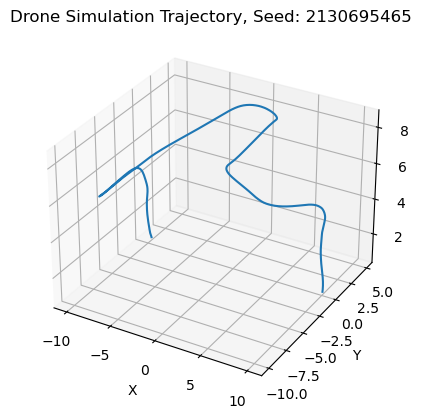

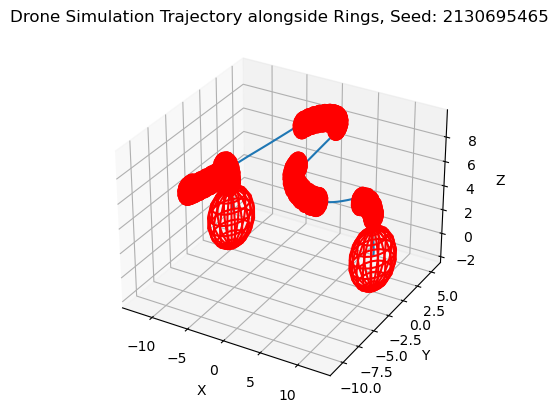

In [105]:
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#this is assuming you have the x,y,z saved from the positions. 
drone_x = data['p_x']
drone_y = data['p_y']
drone_z = data['p_z']

rings = np.array([[0,0,0,0]])

for i, ring in enumerate(simulator.rings):
    p = ring['p']        # <--- position of ring
    v = ring['R'][:, 0]  # <--- unit vector normal to ring (pointing through it)
    r = ring['radius']   # <--- radius of ring
    s = f'ring {i:2d}' + \
        f' : p ({p[0]:6.2f}, {p[1]:6.2f}, {p[2]:6.2f})' + \
        f' : v ({v[0]:6.2f}, {v[1]:6.2f}, {v[2]:6.2f})' + \
        f' : r ({r:6.2f})'
    rings = np.vstack((rings,np.hstack((p,r))))
    
rings = np.delete(rings,0,0)

# to creating a 3d plot
fig = plt.figure(0)
ax = fig.add_subplot(111, projection='3d')


ax.plot3D(drone_x, drone_y, drone_z)  

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Drone Simulation Trajectory, Seed: 2130695465')

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')

ax.plot3D(drone_x, drone_y, drone_z)  

def plot_ring(center, radius):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = center[0] + radius * np.cos(u) * np.sin(v)
    y = center[1] + radius * np.sin(u) * np.sin(v)
    z = center[2] + radius * np.cos(v)
    ax.plot_wireframe(x, y, z, color="r",rstride=1, cstride=1)


for ring in rings:
    plot_ring(ring[0:3], ring[-1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Drone Simulation Trajectory alongside Rings, Seed: 2130695465')
plt.show()

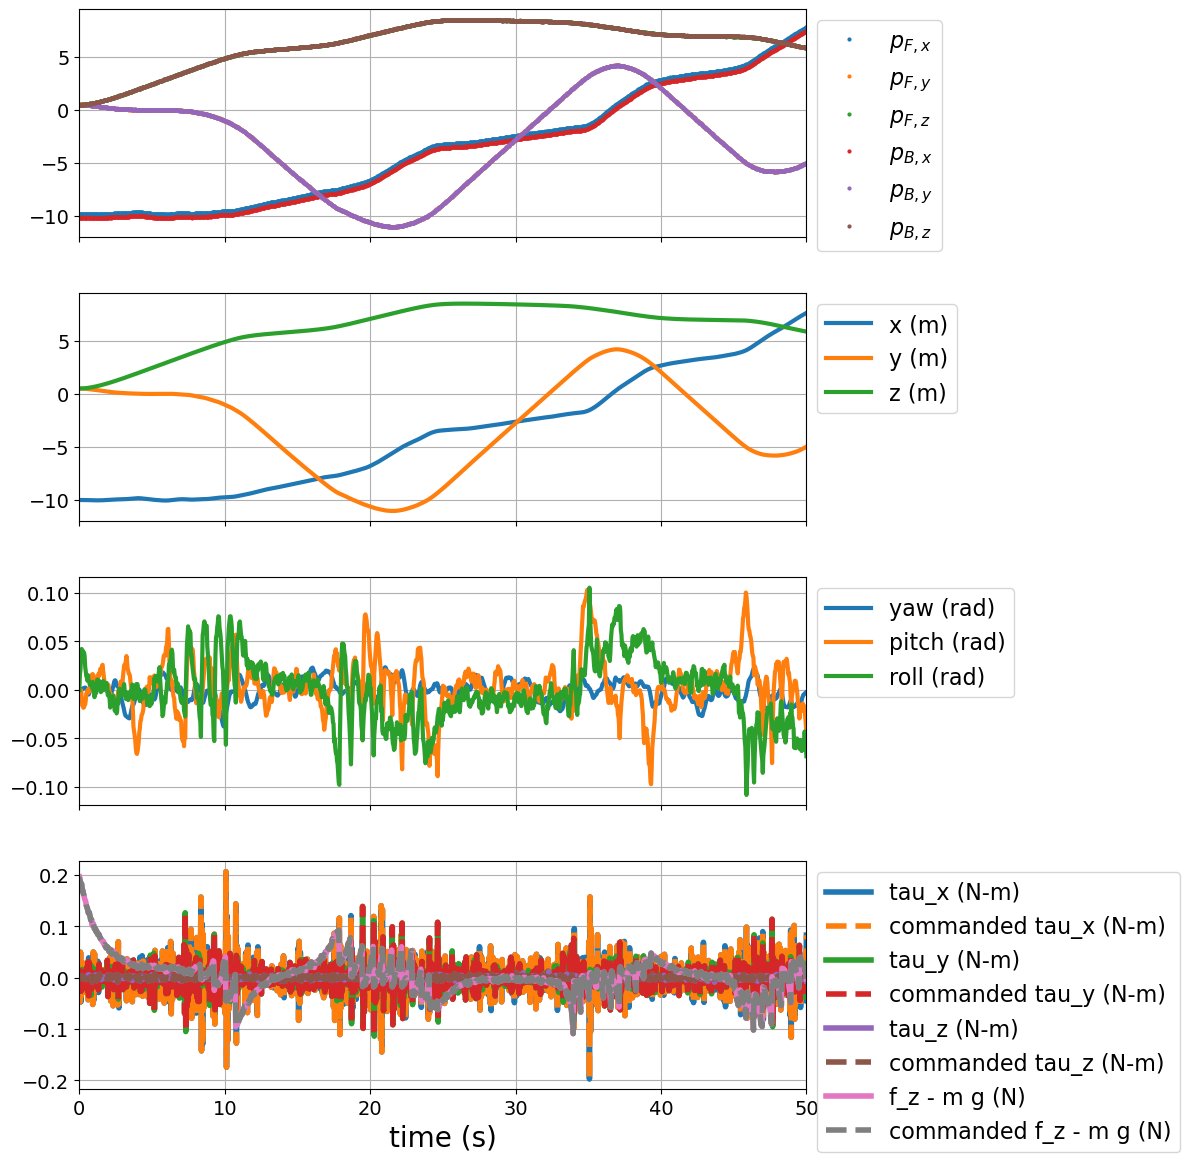

In [72]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_meas, ax_pos, ax_ori, ax_act) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Measurements
ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{F, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{F, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{F, z}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{B, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{B, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{B, z}$')
ax_meas.grid()
ax_meas.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_meas.tick_params(labelsize=14)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()